## Preparation

In [52]:
%matplotlib inline
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
# import mshr
import sys
# import os
# os.environ["CC"]="/usr/bin/gcc"
# os.environ["CXX"]="/usr/bin/g++"
# os.environ["CLANG"]="/usr/bin/clang"
# os.environ["CLANGXX"]="/usr/bin/clang++";
# # os.environ["PYTHON"] = "/anaconda3/bin/python"

$$
u' + u \cdot \nabla(u) - div(\sigma(u, p)) = f\\
                                 div(u) = 0
$$

## Mesh

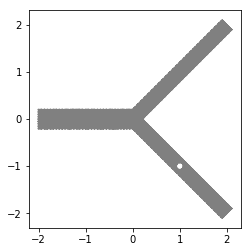

In [82]:
# # Create mesh
# Gx = 2.2
# Gy1 = 0.21
# Gy2 = 0.2
# Gd = 0.15
# Gh1 = sqrt(Gy1**2+Gd**2)
# Gh2 = sqrt(Gy2**2+Gd**2)
# Gs1 = 1.0
# Gs2 = 1.0
# Gt1 = np.arctan(Gd/Gy1)
# Gt2 = np.arctan(Gd/Gy2)
# Gcx = 0.45*Gh2
# Gcy = 0.45*Gh2
# Gr = 0.03
# channel0 = Rectangle(Point(-Gx, -Gy2), Point(0.0, Gy1))
# channel1 = Rectangle(Point(0.0, Gy1-Gh1), Point(Gs1, Gy1))
# channel1 = MeshTransformation.rotate(generate_mesh(channel1,64),Gt1,2,Point(0.0, Gy1, 0.0))
# channel2 = Rectangle(Point(-Gx, -Gy2), Point(0.0, Gy1))
# channel2 = MeshTransformation.rotate(generate_mesh(channel2,64),-Gt2,2,Point(0.0, -Gy2, 0.0))
# triangle = Rectangle(Point(-Gx, -Gy2), Point(0.0, Gy1))
# cylinder = Circle(Point(Gc1, Gc2), Gr)
# domain = channel1 - cylinder
# mesh = generate_mesh(domain, 64)
# plot(mesh)
# from mshr import *
from dolfin import *
from mshr import *
a=.5
b=.2
domain_vertices = [Point(-2.0, -0.2),
                   Point(0.0, -0.2),
                   Point(1.9,-2.1),
                   Point(2.1,-1.9),
                   Point(0.2,0),
                   Point(2.1,1.9),
                   Point(1.9,2.1),
                   Point(0.0,0.2),
                   Point(-2.0,0.2)]
polygon = Polygon(domain_vertices)
k=1.0
EPS = 0.001 # to destroy symmetry and create turbulance
cylinder = Circle(Point(k+EPS,-k+EPS), 0.08)
domain = polygon - cylinder
#     mesh = generate_mesh(domain, 10)
# plot(mesh, interactive=True)
mesh = generate_mesh(domain, 64)
plot(mesh)

## Define Problem

In [83]:
T = .1              # final time
num_steps = 100   # number of time steps # must satisfy CFL condition
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Define boundaries
inflow   = 'near(x[0], -2.0)'
outflow  = 'near(x[0]-x[1], 4) || near(x[0]+x[1], 4)'
walls    = '((near(x[1], -0.2) || near(x[1], 0.2)) && x[0]<=0)' \
            +' || ((near(x[1] - x[0], 0.2) || near(x[1] + x[0], -0.2)) && x[0]>0 )' \
            +' || ((near(x[1] - x[0], -0.2) || near(x[1] + x[0], 0.2)) && x[0]>0.2 ) '
cylinder = 'on_boundary && x[0]>0.91 && x[0]<1.09 && x[1]>-1.09 && x[1]<-0.91'

# Define inflow profile
inflow_profile = ('4.0*1.5*(x[1] + 0.2)*(0.2 - x[1]) / pow(0.4, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None]

## Save Data Structure for future usage (optional)

In [123]:
# # Create XDMF files for visualization output
# xdmffile_u = XDMFFile('navier_stokes_cylinder/velocity.xdmf')
# xdmffile_p = XDMFFile('navier_stokes_cylinder/pressure.xdmf')

# # Create time series (for use in reaction_system.py)
# timeseries_u = TimeSeries('navier_stokes_cylinder/velocity_series')
# timeseries_p = TimeSeries('navier_stokes_cylinder/pressure_series')

# # Save mesh to file (for use in reaction_system.py)
# File('navier_stokes_cylinder/cylinder.xml.gz') << mesh

# # Create progress bar
# # progress = Progress('Time-stepping')
# # set_log_level(PROGRESS)

## Apply Solver

In [124]:
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
#     plot(u_, title='Velocity')
#     plot(p_, title='Pressure')

#     # Save solution to file (XDMF/HDF5)
#     xdmffile_u.write(u_, t)
#     xdmffile_p.write(p_, t)

#     # Save nodal values to file
#     timeseries_u.store(u_.vector(), t)
#     timeseries_p.store(p_.vector(), t)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    # Update progress bar
#     progress.update(t / T)
#     print('u max:', u_.vector().array().max())
    sys.stdout.write('>')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

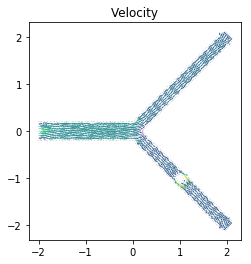

In [85]:
plot(u_, title='Velocity')

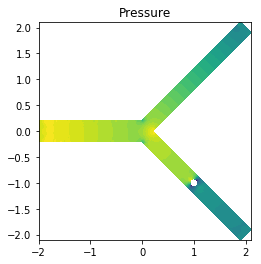

In [86]:
plot(p_, title='Pressure')

## An attempt to extract FENiCS data structure

coor (1531, 2) value (1531,) vertex (1531,) vertex2 (1531,)


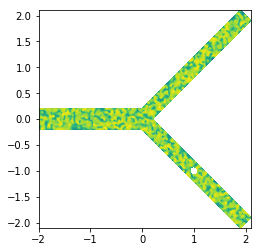

In [87]:
arr = p_.vector().vec()
coor = mesh.coordinates()
# vtd = V.dofmap().dof_to_vertex_map(mesh)
vtd = dof_to_vertex_map(Q)
vtd2 = np.array(Q.dofmap().dofs())

#reshape
v2d = v2d.reshape((-1, mesh.geometry().dim()))

#extract
values = list()
for i, dum in enumerate(coor):
    values.append(arr[vtd[i]])
values = np.array(values)
print('coor',coor.shape,'value',values.shape,'vertex',vtd.shape,'vertex2',vtd2.shape)

#set
# vertex_vector_values = np.zeros(mesh.num_vertices()*2)
# vertex_vector_values[::2] = values[0,:]
# vertex_vector_values[1::2] = values[1,:]
vertex_vector_values = np.zeros(mesh.num_vertices())
vertex_vector_values = values
# vertex_to_dof_map = V.dofmap().vertex_to_dof_map(mesh)#deprecated
dof_to_vertex_map_values = dof_to_vertex_map(Q)

p_test = Function(Q)
p_test.vector().set_local(vertex_vector_values[dof_to_vertex_map_values])
plot(p_test)

### computation above is not working, trying a simpler mesh:

v2d (36, 2) d2v (36,)


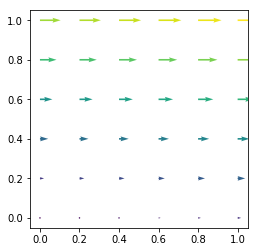

In [120]:
from dolfin import *

mesh = UnitSquareMesh(5,5)
Q = VectorFunctionSpace(mesh, "CG", 1, dim=2)

v2d=vertex_to_dof_map(Q)
d2v=dof_to_vertex_map(Q)

v2d = v2d.reshape((-1, mesh.geometry().dim()))
d2v = d2v[range(0, len(d2v), 2)]/2

# Test
# v = f(1, mesh)
q = Function(Q)

# v.array()[10] = 1.0
# v.array()[25] = 1.0
for i in range(36):
    q.vector()[v2d[i,0]] = i

print('v2d',v2d.shape,'d2v',d2v.shape)
# plot(v)
plot(q)          # press m to visualize the mesh

#here is data structure for function space P2
V.dofmap().tabulate_entity_dofs(1,1)

## Line Integral

In [137]:
def line_integral(u, A, B, n): 
    '''Integrate u over segment [A, B] partitioned into n elements'''
    assert u.value_rank() == 0
    assert len(A) == len(B) > 1 and np.linalg.norm(A-B) > 0
    assert n > 0

    # Mesh line for integration
    mesh_points = [A + t*(B-A) for t in np.linspace(0, 1, n+1)]
    tdim, gdim = 1, len(A)
    mesh = Mesh()
    editor = MeshEditor()
    editor.open(mesh, tdim, gdim)
    editor.init_vertices(n+1)
    editor.init_cells(n)

    for vi, v in enumerate(mesh_points): editor.add_vertex(vi, v)

    for ci in range(n): editor.add_cell(ci, np.array([ci, ci+1], dtype='uintp'))

    editor.close()

    # Setup funcion space
    elm = u.function_space().ufl_element()
    family = elm.family()
    degree = elm.degree()
    V = FunctionSpace(mesh, family, degree)
    v = interpolate(u, V)

    return assemble(v*dx)

mesh = UnitCubeMesh(2, 4, 5)
V = FunctionSpace(mesh, 'CG', 1)
f = Expression('x[0]+x[1]+x[2]', degree=1)
v = interpolate(f, V)

A = np.array([0, 0, 0])
B = np.array([1, 1, 1])

ans = line_integral(v, A, B, n=100)
ans0 = 3*sqrt(3)/2
abs(ans-ans0)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Moving new file over differing existing file:
src: /Users/evergreen/Documents/GitHub/classification/code/jitfailure-ffc_element_1976692f3b42bd5ed8bd6c502117e048e08954bb/error.log.1e507e596d424d3a99b15f8560f7d9ec
dst: /Users/evergreen/Documents/GitHub/classification/code/jitfailure-ffc_element_1976692f3b42bd5ed8bd6c502117e048e08954bb/error.log
backup: /Users/evergreen/Documents/GitHub/classification/code/jitfailure-ffc_element_1976692f3b42bd5ed8bd6c502117e048e08954bb/error.log.old
------------------- Start compiler output ------------------------
ld: warning: ignoring file /Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk/usr/lib/libSystem.tbd, file was built for unsupported file format ( 0x2D 0x2D 0x2D 0x20 0x21 0x74 0x61 0x70 0x69 0x2D 0x74 0x62 0x64 0x2D 0x76 0x33 ) which is not the architecture being linked (x86_64): /Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk/usr/lib/libSystem.tbd
Undefined symbols for architecture x86_64:
  "___bzero", referenced from:
      ff

Compilation failed! Sources, command, and errors have been written to: /Users/evergreen/Documents/GitHub/classification/code/jitfailure-ffc_element_1976692f3b42bd5ed8bd6c502117e048e08954bb


DijitsoError: Dijitso JIT compilation failed, see '/Users/evergreen/Documents/GitHub/classification/code/jitfailure-ffc_element_1976692f3b42bd5ed8bd6c502117e048e08954bb' for details

# Get Raw Value of Solution (forum tutorials, kept here for reference) 

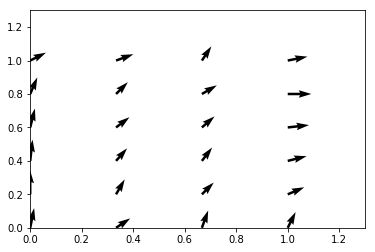

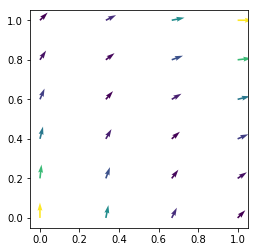

In [6]:
# tutorial from forum https://fenicsproject.org/qa/1460/numpy-arrays-from-fenics-data/
from dolfin import *
import numpy as np
import pylab as pl

mesh = UnitSquareMesh(3,5)
V = VectorFunctionSpace(mesh, "CG", 1)
u = Function(V)

# Vertex based data
vertex_vector_values = np.zeros(mesh.num_vertices()*2)
vertex_vector_values[::2] = mesh.coordinates().sum(1)
vertex_vector_values[1::2] = 2-mesh.coordinates().sum(1)
# vertex_to_dof_map = V.dofmap().vertex_to_dof_map(mesh)
dof_to_vertex_map_values = dof_to_vertex_map(V)

u.vector().set_local(vertex_vector_values[dof_to_vertex_map_values])

####### NOW GO THE OTHER WAY #####

arr = u.vector().vec()
coor = mesh.coordinates()
# vtd = V.dofmap().dof_to_vertex_map(mesh)
vtd = dof_to_vertex_map(V)

values = list()
for i, dum in enumerate(coor):
    values.append([arr[vtd[2*i]],arr[vtd[2*i+1]]])
values = np.array(values)


#################
x = list()
y = list()
vx = list()
vy = list()
for i, dum in enumerate(coor):
#     print '(%f,%f) -> (%f,%f)' %(coor[i][0], coor[i][1], values[i][0], values[i][1])
    x.append(coor[i][0])
    y.append(coor[i][1])
    vx.append(values[i][0])
    vy.append(values[i][1])

pl.quiver(x,y,vx,vy)
pl.axis([0, 1.3, 0, 1.3])
pl.show()
plot(u)

In [7]:
values

array([[0.33333333, 1.66666667],
       [1.2       , 0.8       ],
       [0.53333333, 1.46666667],
       [0.66666667, 1.33333333],
       [0.        , 2.        ],
       [0.73333333, 1.26666667],
       [1.        , 1.        ],
       [1.4       , 0.6       ],
       [0.2       , 1.8       ],
       [0.93333333, 1.06666667],
       [0.86666667, 1.13333333],
       [1.6       , 0.4       ],
       [0.4       , 1.6       ],
       [1.13333333, 0.86666667],
       [1.06666667, 0.93333333],
       [1.8       , 0.2       ],
       [0.6       , 1.4       ],
       [1.        , 1.        ],
       [1.26666667, 0.73333333],
       [2.        , 0.        ],
       [1.33333333, 0.66666667],
       [1.46666667, 0.53333333],
       [0.8       , 1.2       ],
       [1.66666667, 0.33333333]])

In [16]:
# another tutorial
from dolfin import *
mesh = UnitSquareMesh(3,3)
V = FunctionSpace(mesh, "Lagrange", 1)

for (i, cell) in enumerate(cells(V.mesh())):
        print("Global dofs associated with cell %d: " % i)
        print(V.dofmap().cell_dofs(i))
#         print("The Dof coordinates:")
#         print(V.dofmap().tabulate_coordinates(cell))

Global dofs associated with cell 0: 
[ 6 10  7]
Global dofs associated with cell 1: 
[6 3 7]
Global dofs associated with cell 2: 
[10 13 11]
Global dofs associated with cell 3: 
[10  7 11]
Global dofs associated with cell 4: 
[13 15 14]
Global dofs associated with cell 5: 
[13 11 14]
Global dofs associated with cell 6: 
[3 7 4]
Global dofs associated with cell 7: 
[3 1 4]
Global dofs associated with cell 8: 
[ 7 11  8]
Global dofs associated with cell 9: 
[7 4 8]
Global dofs associated with cell 10: 
[11 14 12]
Global dofs associated with cell 11: 
[11  8 12]
Global dofs associated with cell 12: 
[1 4 2]
Global dofs associated with cell 13: 
[1 0 2]
Global dofs associated with cell 14: 
[4 8 5]
Global dofs associated with cell 15: 
[4 2 5]
Global dofs associated with cell 16: 
[ 8 12  9]
Global dofs associated with cell 17: 
[8 5 9]


In [ ]:
## yet another 
import pylab as pl
V = VectorFunctionSpace(mesh, "CG", 1)
u = Function(V)

####### set values from u_

arr = p_.vector().vec()
coor = mesh.coordinates()
# vtd = V.dofmap().dof_to_vertex_map(mesh)#deprecated
# vtd = dof_to_vertex_map(V)#useful only for "CG1" space # https://fenicsproject.org/qa/10767/dof_to_vertex_map-dolfin-1-3-0/
# values = list()
# n=mesh.num_vertices()
# for i in range(n):
# #     values.append([arr[vtd[2*i]],arr[vtd[2*i+1]]])
#     values.append([arr[myx[i]],arr[myy[i]]])
# values = np.array(values)

myx = interpolate(Expression("x[0]",degree=2), FunctionSpace(mesh,'CG',1)).vector()
myy = interpolate(Expression("x[1]",degree=2), FunctionSpace(mesh,'CG',1)).vector()
# myz = interpolate(Expression("x[2]"), FunctionSpace(mesh,'CG',2)).vector()
myx=myx.vec()[:]
myy=myy.vec()[:]
values=np.array([myx,myy])


####### set values to u
vertex_vector_values = np.zeros(mesh.num_vertices()*2)
vertex_vector_values[::2] = values[0,:]
vertex_vector_values[1::2] = values[1,:]
# vertex_to_dof_map = V.dofmap().vertex_to_dof_map(mesh)
dof_to_vertex_map_values = dof_to_vertex_map(V)

u.vector().set_local(vertex_vector_values[dof_to_vertex_map_values])

In [ ]:
import SolveParamNS

In [ ]:
# getting data from h5
import h5py
filename = 'navier_stokes_cylinder/velocity.h5'
f = h5py.File(filename, 'r')

# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

# # Get the data
# data = list(f[a_group_key]
f["Mesh"].values()

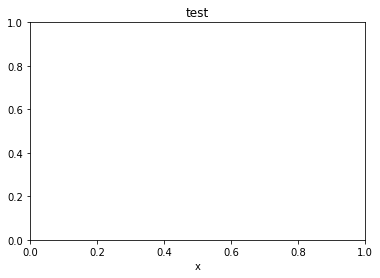

In [142]:
# to make an animation with built-in matplotlib method

import matplotlib.animation as animation
def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,
fig1 = plt.figure()

# Fixing random state for reproducibility
# np.random.seed(19680801)

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)
plt.show()